In [1]:
import psycopg2
import pandas as pd
import sqlite3
import numpy as np
from sklearn.cluster import KMeans
from collections import OrderedDict
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
%matplotlib inline

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "db_ds_students",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
sql_string_test = "SELECT table_name FROM information_schema.tables  WHERE table_schema='public';"

cursor.execute(sql_string_test)
name_table = cursor.fetchall()
name_table = [a[0] for a in name_table]
print(cursor.description)
conn.close()

(Column(name='table_name', type_code=1043),)


In [2]:
def chisqlite():
    'Позволяет просматривать таблицы в Postgresql'
    conn = psycopg2.connect(**pg_connection)
    cursor = conn.cursor()
    print(sorted(name_table))
    chosen_table = input('Выберите таблицу из вышепредставленных:')
    index_table = name_table.index(chosen_table)
    sql_string = "SELECT column_name, data_type FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name =  '{}' ;".format(name_table[index_table])
    cursor.execute(sql_string)
    columns = cursor.fetchall()
    column_names = [a for a, b in columns]
    print('Названия колонок в выбранной таблице: {}'.format(sorted(column_names)))
    selector = input('SELECT {ваш ввод} (по умолчанию *)')
    if len(selector) == 0:
        selector = '*'
    where = input('Введите условие WHERE {ваш ввод} (по умолчанию отсутствует)')
    if len(where) > 0:
        where = 'WHERE {}'.format(where)
    grouper = input('Введите GROUP BY {ваш ввод} (по умолчанию отсутствует)')
    if len(grouper) > 0:
        grouper = 'GROUP BY {}'.format(grouper)
    order = input('Введите ORDER BY {ваш ввод} (по умолчанию отсутствует)')
    if len(order) > 0:
        order = 'ORDER BY {}'.format(order)
    sql_string = 'SELECT {cols} FROM {name_table} {where} {grouper} {order};'.format(cols = selector, name_table = name_table[index_table], where = where, order = order, grouper = grouper)
    cursor.execute(sql_string)
    res = cursor.fetchall()

    conn.close()

    try:
        res_df = pd.DataFrame(res, columns = column_names)
    except:
        if selector != '*':
            res_df = pd.DataFrame(res, columns = selector.split(', '))
        else:
            res_df = pd.DataFrame(res)
    return res_df

In [3]:
table = chisqlite()

['course_purchases', 'exploratory', 'keywords', 'links', 'ratings']


Выберите таблицу из вышепредставленных: exploratory


Названия колонок в выбранной таблице: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']


SELECT {ваш ввод} (по умолчанию *) 
Введите условие WHERE {ваш ввод} (по умолчанию отсутствует) 
Введите GROUP BY {ваш ввод} (по умолчанию отсутствует) 
Введите ORDER BY {ваш ввод} (по умолчанию отсутствует) 


In [4]:
table

,feature_1,feature_2,feature_3,feature_4,feature_5
0,2.4399302341553932,-2.180960698389708,33.4684964804719,-1.9273880121739875,-5.3213919475057105
1,1.7705797495879034,-1.174880454210172,0.9895926481354946,-1.1396809115663187,-2.0802195404111687
2,0.7428169764168391,-0.2634829113111655,0.16814863490368492,-0.3324379721161745,-0.19571957951766614
3,-1.510891800324271,2.7125712625192238,-2.6856430298672915,2.0584952423727403,-4.098401678335551
4,-0.4835110394772655,0.096511221663355,-0.028703495808161117,0.1687629004635419,-0.04666424110766956
...,...,...,...,...,...
95,0.10764850635557899,-3.101785656930369,56.49091243959598,-1.9937680914933749,-0.33390259300371256
96,1.759629548272443,-1.4285652188163707,1.2644422383976943,-1.29835370396105,-2.513745570663574
97,0.8438229416103058,1.1876556600977073,-1.4100261703323511,0.566680768339602,1.0021710927237768
98,0.8671537593957526,1.1115564316783124,-1.3317181504522202,0.5131668559607284,0.9638903385103766


In [5]:
for x in table:
    table[x] = table[x].astype('float64')

In [6]:
table.isnull().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
dtype: int64

feature_1
feature_2
feature_3
feature_4
feature_5


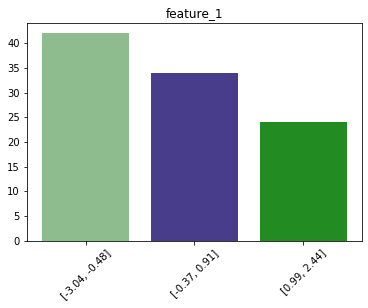

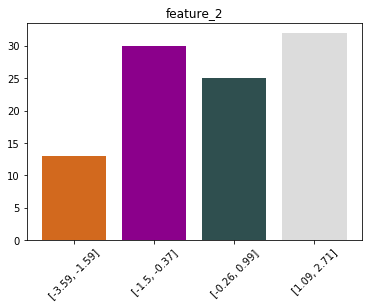

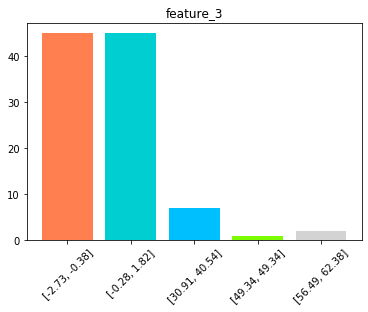

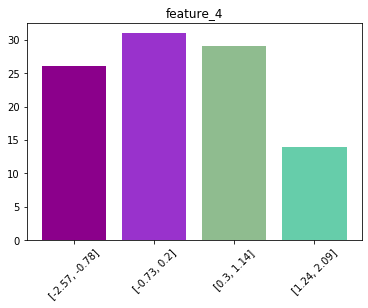

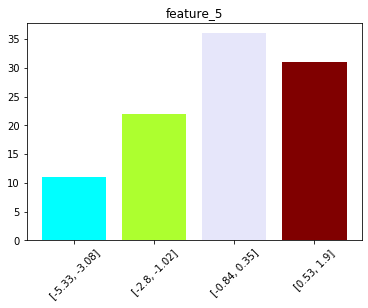

In [21]:
dct = {}
borders_dict = {}
values_dict = {}
for col in table.columns:
    print(col)
    dct2 = {}
    dct3 = {}
    mins = {}
    maxs = {}
    borders = {}
    lenn = len(table[col])
    X = table[col].values.reshape(-1, 1)
    pas = False
    pas2 = False
    fig, ax = plt.subplots()
    digit = range(1,10)
    indexes = range(2, 10)
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for d in digit:
        clust = KMeans(n_clusters=d).fit(X)
        distortions.append(sum(np.min(cdist(X, clust.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0])
        inertias.append(clust.inertia_)
        mapping1[d] = sum(np.min(cdist(X, clust.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]
        mapping2[d] = clust.inertia_
    for index in indexes:
        if (mapping2[index+1] / mapping2[index] > 0.67) and (mapping2[index-1] / 1.5 > mapping2[index]):
            dct[col] = index - 1
            break
    clust = KMeans(n_clusters=dct[col]).fit(X)
    for f in clust.predict(X):
            if f not in dct2:
                dct2[f] = 1
            else:
                dct2[f] += 1
    centres = [round(float(x), 2) for x in clust.cluster_centers_]
    for i in range(len(dct2)):
        dct3[centres[i]] = dct2[i]
    dct3 = dict(OrderedDict(sorted(dct3.items(), key=lambda t: t[0])))
    for x in range(len(X)):
        if clust.predict(X)[x] not in maxs:
            maxs[clust.predict(X)[x]] = X[x]
        elif maxs[clust.predict(X)[x]] < X[x]:
            maxs[clust.predict(X)[x]] = X[x]
    for x in range(len(X)):
        if clust.predict(X)[x] not in mins:
            mins[clust.predict(X)[x]] = X[x]
        elif mins[clust.predict(X)[x]] > X[x]:
            mins[clust.predict(X)[x]] = X[x]
    distant = {}
    for i in range(len(dct2)):
        borders[centres[i]] = [round(float(mins[i]), 2), round(float(maxs[i]), 2)]
        distant[centres[i]] = (abs(round(float(maxs[i]), 2)) - round(float(mins[i]), 2))
    for elem in distant:
        distant[elem] = distant[elem] / sum((distant.values())) 
    distant = dict(OrderedDict(sorted(distant.items(), key=lambda t: t[0])))
    borders = dict(OrderedDict(sorted(borders.items(), key=lambda t: t[0])))
    borders_dict[col] = borders
    values_dict[col] = dct3
    ax.set_title(col)
    plt.xticks(rotation = 45)
    color_indexes = list(np.random.randint(0, 100, len(centres)))
    colors = []
    for c in list(cnames.keys()):
        if list(cnames.keys()).index(c) in color_indexes:
            colors.append(c)
    #  width = distant,
    ax.bar(np.arange(dct[col]), list(dct3.values()), align = 'center', color = colors, tick_label = [str(x) for x in list(borders.values())])
#Как красиво отобразить 3?

In [9]:
values_dict
# Количество значений по колонкам

{'feature_1': {-1.41: 39, 0.34: 36, 1.44: 25},
 'feature_2': {-2.45: 9, -1.13: 30, 0.16: 26, 1.59: 35},
 'feature_3': {-1.41: 45, 0.79: 45, 36.52: 7, 49.34: 1, 59.44: 2},
 'feature_4': {-1.27: 26, -0.23: 31, 0.76: 29, 1.58: 14},
 'feature_5': {-4.09: 11, -1.77: 22, -0.24: 36, 1.04: 31}}

In [10]:
borders_dict
# Границы колонок

{'feature_1': {-1.41: [-3.04, -0.61], 0.34: [-0.5, 0.87], 1.44: [0.91, 2.44]},
 'feature_2': {-2.45: [-3.59, -1.88],
  -1.13: [-1.75, -0.5],
  0.16: [-0.46, 0.82],
  1.59: [0.96, 2.71]},
 'feature_3': {-1.41: [-2.73, -0.38],
  0.79: [-0.28, 1.82],
  36.52: [30.91, 40.54],
  49.34: [49.34, 49.34],
  59.44: [56.49, 62.38]},
 'feature_4': {-1.27: [-2.57, -0.78],
  -0.23: [-0.73, 0.2],
  0.76: [0.3, 1.14],
  1.58: [1.24, 2.09]},
 'feature_5': {-4.09: [-5.33, -3.08],
  -1.77: [-2.8, -1.02],
  -0.24: [-0.84, 0.35],
  1.04: [0.53, 1.9]}}

In [11]:
promezh = {}
for feature in borders_dict:
    promezh[feature] = {}
    for v in borders_dict[feature]:
        promezh[feature][v] = [borders_dict[feature][v],(values_dict[feature][v])]
# Логическое соединение границ промежутков и значений в них

In [12]:
for x in promezh:
    print(f'Отрезки в {x}:')
    for y in promezh[x]:
        print(f'Промежуток {promezh[x][y][0]} содержит {promezh[x][y][1]} элементов')
    else:
        print('------------')
# Описал данные

Отрезки в feature_1:
Промежуток [-3.04, -0.61] содержит 39 элементов
Промежуток [-0.5, 0.87] содержит 36 элементов
Промежуток [0.91, 2.44] содержит 25 элементов
------------
Отрезки в feature_2:
Промежуток [-3.59, -1.88] содержит 9 элементов
Промежуток [-1.75, -0.5] содержит 30 элементов
Промежуток [-0.46, 0.82] содержит 26 элементов
Промежуток [0.96, 2.71] содержит 35 элементов
------------
Отрезки в feature_3:
Промежуток [-2.73, -0.38] содержит 45 элементов
Промежуток [-0.28, 1.82] содержит 45 элементов
Промежуток [30.91, 40.54] содержит 7 элементов
Промежуток [49.34, 49.34] содержит 1 элементов
Промежуток [56.49, 62.38] содержит 2 элементов
------------
Отрезки в feature_4:
Промежуток [-2.57, -0.78] содержит 26 элементов
Промежуток [-0.73, 0.2] содержит 31 элементов
Промежуток [0.3, 1.14] содержит 29 элементов
Промежуток [1.24, 2.09] содержит 14 элементов
------------
Отрезки в feature_5:
Промежуток [-5.33, -3.08] содержит 11 элементов
Промежуток [-2.8, -1.02] содержит 22 элементов


In [13]:
for x in table:
    table[x] = table[x].astype('float64')

In [14]:
table.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], dtype='object')

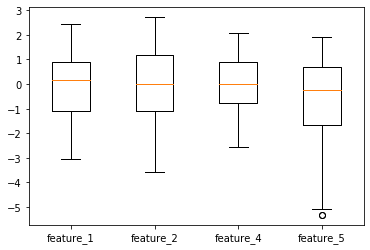

In [15]:
fig, ax = plt.subplots()

plt.boxplot([table['feature_1'], table['feature_2'], table['feature_4'], table['feature_5']], labels = ['feature_1', 'feature_2', 'feature_4', 'feature_5'])
plt.show()

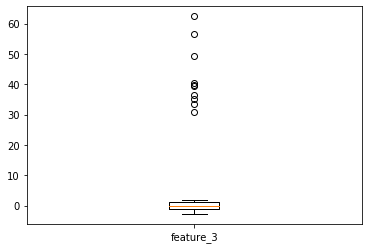

In [16]:
fig, ax = plt.subplots()

plt.boxplot(table['feature_3'], labels = ['feature_3'])
plt.show()

Куча выбросов в 3 (10 процентов)

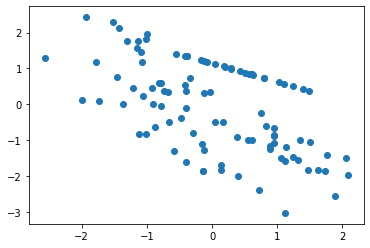

In [17]:
fig, ax = plt.subplots()
ax.scatter(table['feature_4'], table['feature_1'])
plt.show()

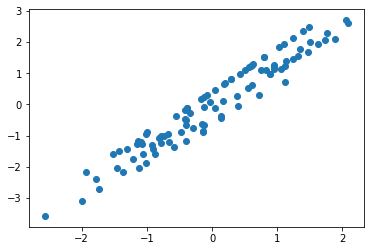

In [18]:
fig, ax = plt.subplots()
ax.scatter(table['feature_4'], table['feature_2'])
plt.show()

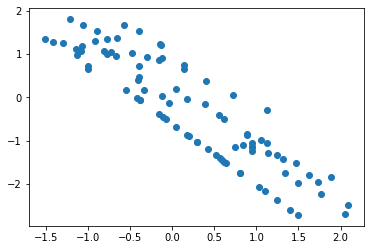

In [19]:
fig, ax = plt.subplots()
ax.scatter(table['feature_4'].drop(index = list(table[table['feature_3'] > 20]['feature_3'].index)), table[table['feature_3'] < 20]['feature_3'])
plt.show()

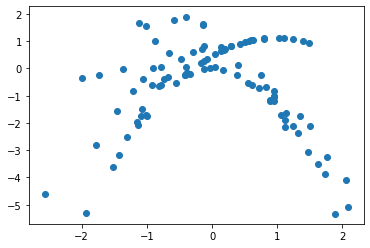

In [20]:
fig, ax = plt.subplots()
ax.scatter(table['feature_4'], table['feature_5'])
plt.show()

Третью, (после очистки значений) и вторую